# Forecasting returns with sentiment analysis

## Global methodology

In this project we aimed to use sentiment analysis and macroeconomic datas to predict the future returns of financial assets from the S&P500. To do so, the main idea was to use the daily macroeconomic data as an other feature in each model and financial news sentiment that we scrapped from the website https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?name_of_publication=Press%20release. The different ways we use those datas are explained through the notebook.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import seaborn  as sns

**Result**: the LSTM is pretty bad when trained on individual financial time series, instead, we'll use the first 100 time series to predict 1, hence the model we'll include the correlations between the different time series.

## Downloading data

*ADD PYTHON SCRIPT TO PERFORM THE SCRAPING IN THIS SECTION (imports or brut code ?)*

## Import data

### S&P500 Prices

In [2]:
import pandas as pd

df = pd.read_csv('data/sp500_prices.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)  # Convert to UTC datetime
companies = df['Company'].unique().tolist()
dates = df['Date'].drop_duplicates().values

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Company
0,2017-01-03 00:00:00+00:00,149.523407,150.501678,148.177261,148.871231,3001123,3M
1,2017-01-03 00:00:00+00:00,49.150002,49.250000,48.669998,49.040001,3974400,Southern Company
2,2017-01-03 00:00:00+00:00,65.290001,65.800003,63.700001,65.029999,2710300,Baker Hughes
3,2017-01-03 00:00:00+00:00,65.860001,66.139999,64.599998,65.400002,9519800,Qualcomm
4,2017-01-03 00:00:00+00:00,55.669998,56.349998,55.459999,56.000000,22063800,Wells Fargo


### Textual Data for sentiment analysis

In [20]:
news = pd.read_csv('data/ecb_press_releases.csv')
news = news.dropna()
news["date"] = pd.to_datetime(news["date"], format="%d %B %Y")

In [21]:
news.head()

,date,title,url,text
0,2024-12-04,ECB announces new timeline for harmonisation o...,https://www.ecb.europa.eu/press/pr/date/2024/h...,4 December 2024 The European Central Bank (ECB...
1,2024-12-02,ECB publishes second progress report on the di...,https://www.ecb.europa.eu/press/pr/date/2024/h...,2 December 2024 The European Central Bank (ECB...
2,2024-11-29,ECB announces changes to the Eurosystem collat...,https://www.ecb.europa.eu/press/pr/date/2024/h...,29 November 2024 The Governing Council of the ...
3,2024-11-29,ECB Consumer Expectations Survey results – Oct...,https://www.ecb.europa.eu/press/pr/date/2024/h...,29 November 2024 Compared with September 2024:...
4,2024-11-29,"Norway joins TIPS, adding Norwegian krone to E...",https://www.ecb.europa.eu/press/pr/date/2024/h...,29 November 2024 The European Central Bank (EC...


In [22]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538 entries, 0 to 539
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    538 non-null    datetime64[ns]
 1   title   538 non-null    object        
 2   url     538 non-null    object        
 3   text    538 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 21.0+ KB


In [23]:
dates = news['date'].values

### FinBERT import

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
class_labels = model.config.id2label
prob_labels = model.config.label2id

# Example text (replace with your data)
text1 = news['text'].values[0]

# Tokenize the input text
inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)

# Get predicted probabilities (softmax output)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get predicted class
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Predicted class: neutral
Probabilities: tensor([[0.2126, 0.0084, 0.7790]])


In [25]:
# Check the label
prob_labels

{'positive': 0, 'negative': 1, 'neutral': 2}

In [26]:
from tqdm import tqdm

news['negative'] = 0.0
news['neutral'] = 0.0
news['positive'] = 0.0

# Process each text in the DataFrame
for index, row in tqdm(news.iterrows()):
    text = row['text']
    
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predicted probabilities (softmax output)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
    
    # Assign probabilities to the corresponding columns
    news.at[index, 'positive'] = probs[0]
    news.at[index, 'negative'] = probs[1]
    news.at[index, 'neutral'] = probs[2]

# Display the updated DataFrame
news.head()

538it [00:58,  9.27it/s]


,date,title,url,text,negative,neutral,positive
0,2024-12-04,ECB announces new timeline for harmonisation o...,https://www.ecb.europa.eu/press/pr/date/2024/h...,4 December 2024 The European Central Bank (ECB...,0.008384,0.779022,0.212594
1,2024-12-02,ECB publishes second progress report on the di...,https://www.ecb.europa.eu/press/pr/date/2024/h...,2 December 2024 The European Central Bank (ECB...,0.012294,0.902229,0.085478
2,2024-11-29,ECB announces changes to the Eurosystem collat...,https://www.ecb.europa.eu/press/pr/date/2024/h...,29 November 2024 The Governing Council of the ...,0.018702,0.823225,0.158073
3,2024-11-29,ECB Consumer Expectations Survey results – Oct...,https://www.ecb.europa.eu/press/pr/date/2024/h...,29 November 2024 Compared with September 2024:...,0.955524,0.021545,0.022932
4,2024-11-29,"Norway joins TIPS, adding Norwegian krone to E...",https://www.ecb.europa.eu/press/pr/date/2024/h...,29 November 2024 The European Central Bank (EC...,0.008858,0.731962,0.259180


In [27]:
news = news.drop(columns=['title', 'url', 'text'])

In [28]:
news.head()

,date,negative,neutral,positive
0,2024-12-04,0.008384,0.779022,0.212594
1,2024-12-02,0.012294,0.902229,0.085478
2,2024-11-29,0.018702,0.823225,0.158073
3,2024-11-29,0.955524,0.021545,0.022932
4,2024-11-29,0.008858,0.731962,0.259180


In [ ]:
news = news.groupby("date").mean().reset_index()
date_range = pd.date_range(start=news["date"].min(), end=news["date"].max())
news = news.set_index("date").reindex(date_range)
news = news.ffill().reset_index()
news.rename(columns={"index": "date"}, inplace=True)
news = news.sort_values(by="date", ascending=False).reset_index(drop=True)

In [34]:
news.head(10)

,date,negative,neutral,positive
0,2024-12-04,0.008384,0.779022,0.212594
1,2024-12-03,0.012294,0.902229,0.085478
2,2024-12-02,0.012294,0.902229,0.085478
3,2024-12-01,0.327695,0.525577,0.146728
4,2024-11-30,0.327695,0.525577,0.146728
5,2024-11-29,0.327695,0.525577,0.146728
6,2024-11-28,0.917441,0.018686,0.063873
7,2024-11-27,0.917441,0.018686,0.063873
8,2024-11-26,0.917441,0.018686,0.063873
9,2024-11-25,0.917441,0.018686,0.063873


In [15]:
news['date'] = pd.to_datetime(news['date'])

In [35]:
# Ensure the date columns are in the same format
news['date'] = pd.to_datetime(news['date']).dt.tz_localize(None)  # Remove timezone
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)  # Ensure Date is in datetime format

# Merging
merged_df = pd.merge(df, news, left_on='Date', right_on='date', how='inner')

# Drop the 'Time' column if it exists
if 'Time' in merged_df.columns:
    merged_df.drop(columns=['Time'], inplace=True)

             Date        Open        High         Low       Close    Volume  \
0      2017-03-28   75.830002   76.779999   75.809998   76.550003   2561000   
1      2017-03-28   31.083332   31.503332   31.059999   31.410000    543000   
2      2017-03-28  132.690002  133.529999  132.300003  133.139999   2589700   
3      2017-03-28   23.400000   23.809999   23.370001   23.730000   3967600   
4      2017-03-28   72.970001   73.290001   72.839996   73.190002   5587300   
...           ...         ...         ...         ...         ...       ...   
949508 2024-12-04   23.450001   23.525000   22.174999   23.160000  27219800   
949509 2024-12-04  133.979996  133.990005  129.289993  130.600006   2594900   
949510 2024-12-04  454.720001  464.869995  450.000000  463.980011   1220600   
949511 2024-12-04  171.919998  173.589996  170.934998  172.259995    880600   
949512 2024-12-04   62.020000   62.070000   60.980000   61.060001   2167200   

                           Company       date  nega

In [36]:
merged_df.head()

,Date,Open,High,Low,Close,Volume,Company,date,negative,neutral,positive
0,2017-03-28,75.830002,76.779999,75.809998,76.550003,2561000,Dollar Tree,2017-03-28,0.010145,0.619883,0.369972
1,2017-03-28,31.083332,31.503332,31.059999,31.410000,543000,Arch Capital Group,2017-03-28,0.010145,0.619883,0.369972
2,2017-03-28,132.690002,133.529999,132.300003,133.139999,2589700,J.M. Smucker Company (The),2017-03-28,0.010145,0.619883,0.369972
3,2017-03-28,23.400000,23.809999,23.370001,23.730000,3967600,PulteGroup,2017-03-28,0.010145,0.619883,0.369972
4,2017-03-28,72.970001,73.290001,72.839996,73.190002,5587300,Altria,2017-03-28,0.010145,0.619883,0.369972


In [37]:
companies = merged_df['Company'].unique().tolist()
dates = merged_df['Date'].drop_duplicates().values

### Preprocessing the datasets

In [116]:
from tqdm import tqdm
import numpy as np

data = []
features = 200
for company in tqdm(companies[:features]):
    company_data = merged_df[merged_df['Company'] == company]['High'].values
    company_data = (company_data[1:] - company_data[:-1]) / company_data[:-1]  # Compute returns
    data.append(company_data)

data = np.array(data)  # Shape: (features, timesteps)
sentiment_data = []

for date in tqdm(dates[1:]):
    sentiment_data_day = merged_df[merged_df['Date'] == date][['negative', 'positive', 'neutral']].drop_duplicates().values.flatten()
    sentiment_data.append(sentiment_data_day)

sentiment_data = np.array(sentiment_data)  # Shape: (timesteps, sentiment_features)

if data.shape[1] != sentiment_data.shape[0]:
    raise ValueError(f"Mismatch in timesteps: company_data ({data.shape[1]}) vs sentiment_data ({sentiment_data.shape[0]})")

sentiment_data = sentiment_data.T  # Shape: (sentiment_features, timesteps)

data = np.concatenate((data, sentiment_data), axis=0)  # Shape: (features + sentiment_features, timesteps)

print("Combined data shape:", data.shape)

100%|██████████| 1935/1935 [00:01<00:00, 1008.91it/s]

Combined data shape: (203, 1935)


In [117]:
data.shape

(203, 1935)

In [118]:
data[-3]

array([0.0101447 , 0.0101447 , 0.29216239, ..., 0.01229363, 0.01229363,
       0.00838399])

Here, one feature corresponds to a time series and we added the sentiment analysis as a feature.

### Plotting features

#### Company returns

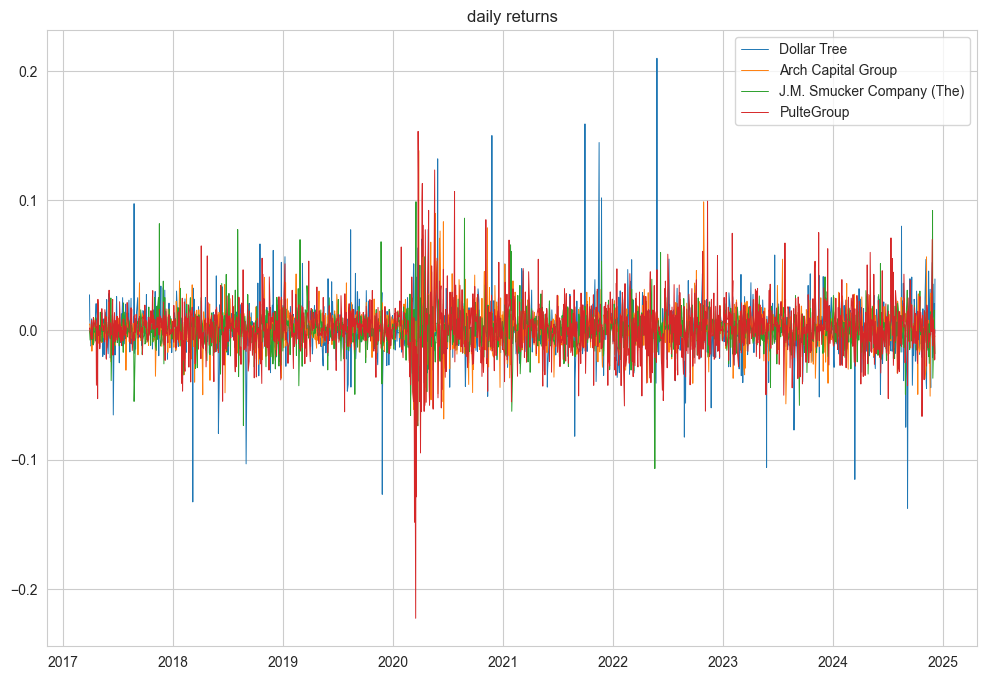

In [119]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
for k in range(4):
    plt.plot(dates[1:], data[k], label=companies[k], linewidth=0.7)
plt.title('daily returns')
plt.legend()
plt.show()

#### Sentiment probabilities

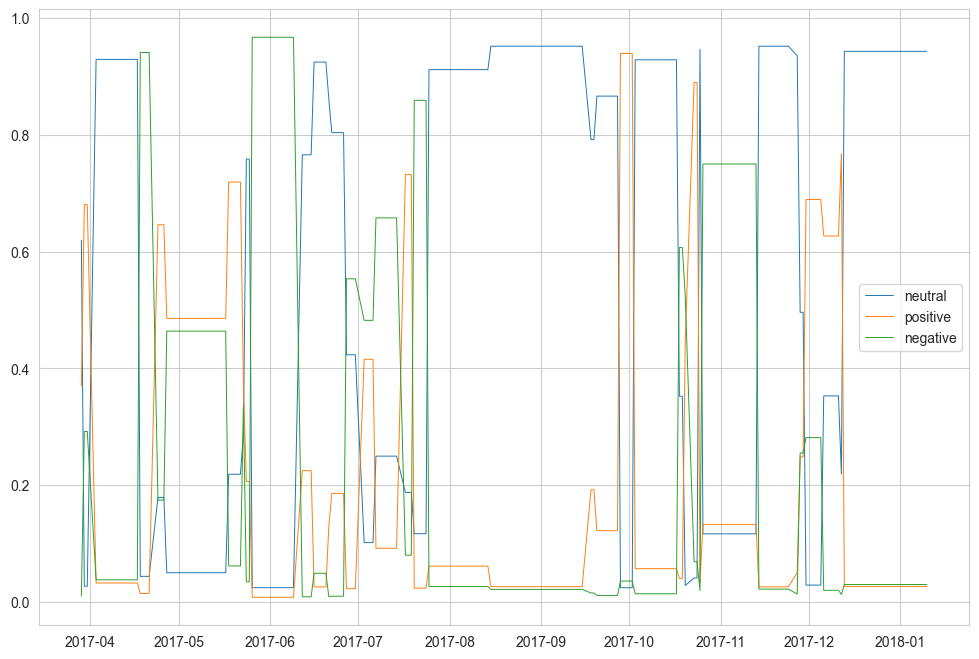

In [120]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
plt.plot(dates[1:200], data[-1, 1:200], label='neutral', linewidth=0.7)
plt.plot(dates[1:200], data[-2, 1:200], label='positive', linewidth=0.7)
plt.plot(dates[1:200], data[-3, 1:200], label='negative', linewidth=0.7)
plt.legend()

In [122]:
data.shape

(203, 1935)

### Multivariate Time Series Sequenced 

In [131]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

sequence_length = 100
data_sequenced = []

for i in range(len(data[0]) - sequence_length):
    data_sequenced.append(data[:, i:i+sequence_length])
data_sequenced = np.array(data_sequenced) # Shape : (num_sequences, num_series, timesteps=sequence_length-1)

X_scaled_sequenced = torch.tensor(data_sequenced, dtype=torch.float32)
X_tensors = X_scaled_sequenced[:, :, :-1]  # All but the last value as features
y_tensors = X_scaled_sequenced[:, :-3, -1]   # Last value as target, without the sentiment

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_tensors, y_tensors, test_size=0.2, random_state=42)

# Create DataLoader for batching
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [132]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)

X_train shape : torch.Size([1468, 203, 99])
y_train shape : torch.Size([1468, 200])


## Models

### LSTM

In [133]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, intermediate_size=256, dropout=0.2):
        super(LSTM, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(intermediate_size, intermediate_size)
        self.tanh = nn.Tanh()
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(intermediate_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states to zeros
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)  # Cell state
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the last time step's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Fully connected layer to produce the final output
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.dropout2(out)
        out = self.fc3(out) # Shape: (batch_size, output_size)
        
        return out

## Early Stopping

In [134]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            path (str): Path to save the best model.
            verbose (bool): Print messages about early stopping.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save the model when validation loss improves."""
        if self.verbose:
            print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        torch.save(model.state_dict(), self.path)

## Training

### LSTM

In [135]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

# Hyperparameters
hidden_size = 128
num_layers = 6
dropout = 0.1

learning_rate = 0.02
num_epochs = 200

# Initialize the LSTM model
model = LSTM(input_size, hidden_size, output_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=50, verbose=True)

### Training Loop

In [136]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.permute(0, 2, 1)  # Shape: (batch_size, sequence_length, input_size)
        y_batch = y_batch  # Shape: (batch_size, num_features)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.permute(0, 2, 1)  # Shape: (batch_size, sequence_length, input_size)
            y_batch = y_batch  # Shape: (batch_size, num_features)
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"\nEpoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")

    # Check early stopping
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("\n     ###################     \n Early stopping triggered \n     ###################     ")
        break


Epoch 1, Train Loss: 0.120891, Validation Loss: 0.000350
Validation loss decreased to 0.000350. Saving model...

Epoch 2, Train Loss: 0.000482, Validation Loss: 0.000335
Validation loss decreased to 0.000335. Saving model...

Epoch 3, Train Loss: 0.000426, Validation Loss: 0.000329
Validation loss decreased to 0.000329. Saving model...

Epoch 4, Train Loss: 0.000400, Validation Loss: 0.000339
EarlyStopping counter: 1 out of 50

Epoch 5, Train Loss: 0.000390, Validation Loss: 0.000332
EarlyStopping counter: 2 out of 50

Epoch 6, Train Loss: 0.000384, Validation Loss: 0.000329
Validation loss decreased to 0.000329. Saving model...

Epoch 7, Train Loss: 0.000384, Validation Loss: 0.000330
EarlyStopping counter: 1 out of 50

Epoch 8, Train Loss: 0.000383, Validation Loss: 0.000330
EarlyStopping counter: 2 out of 50

Epoch 9, Train Loss: 0.000385, Validation Loss: 0.000331
EarlyStopping counter: 3 out of 50

Epoch 10, Train Loss: 0.000383, Validation Loss: 0.000334
EarlyStopping counter: 4

## Evaluation

In [137]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.permute(0, 2, 1)  # Add feature dimension
        y_batch = y_batch

        # Forward pass
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # Multiply by batch size to account for averaging

    # Calculate the average loss over the entire test set
    test_loss = total_loss / len(val_loader.dataset)
    print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.000354


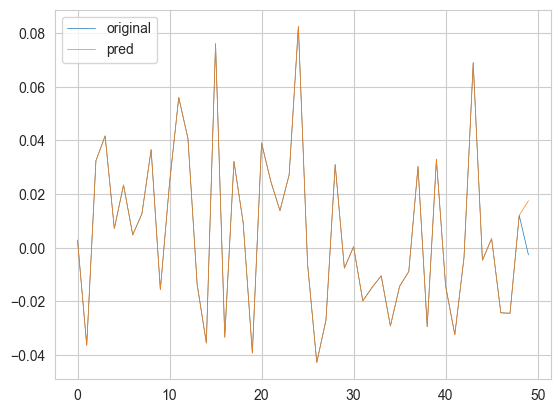

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly pick a sample from the validation set
i = np.random.randint(0, X_val.shape[0])
j = np.random.randint(0, X_val.shape[1])
with torch.no_grad():
    # Prepare input
    x = X_val[i].unsqueeze(0).permute(0, 2, 1)  # Shape: (1, sequence_length, input_size)
    y = y_val[i].unsqueeze(0)  # Shape: (1, num_features)

    # Predict
    y_pred = model(x)  # Shape: (1, num_features)

    # Convert tensors to NumPy arrays for processing
    x = x.squeeze(0).permute(1, 0).numpy()[:-3, :]  # Shape: (sequence_length, input_size)
    y = y.squeeze(0).numpy()  # Shape: (num_features,)
    y_pred = y_pred.squeeze(0).numpy()  # Shape: (num_features,)


    # Append the predicted and actual target values as the last "step" in the input sequence
    x_org = np.concatenate((x, y.reshape(-1, 1)), axis=1)[j]  # Append `y_resized` as the last step
    x_pred = np.concatenate((x, y_pred.reshape(-1, 1)), axis=1)[j]  # Append `y_pred_resized` as the last step
    # Extract the last 50 points for visualization
    x_org_last = x_org[-50:]
    x_pred_last = x_pred[-50:]

    # Plot the original and predicted sequences
    plt.plot(x_org_last, linewidth=0.5, label="original")  # Plot the last feature dimension
    plt.plot(x_pred_last, linewidth=0.5, label="pred")    # Plot the last feature dimension
    plt.legend()
    plt.show()